In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.4.1


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')


84131840/84125825 [==============================] - 12s 0us/step


In [6]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [7]:
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'imdbEr.txt', 'test', 'README']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'urls_neg.txt',
 'neg',
 'unsup',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos']

In [16]:
sample_file = os.path.join(train_dir, 'pos/10000_8.txt')
with open(sample_file) as f:
  print(f.read())

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

In [17]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [18]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [23]:
for x, y in raw_train_ds.take(1):
  for i in range(3):
    print(x[i].numpy())
    print(y[i].numpy())

b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
0
b"I am shocked. Shocked and dismayed that the 428 of you IMDB users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a C!. If I could give FOBH a 20, I'd gladly do it. This film ranks high atop the pantheon of modern comedy, alongside Half Baked and Mallrats, as one of the most hilarious films of all time. If you know _anything_ about rap music - YOU MUST SEE THIS!! If you know nothing about rap music - learn something!, and then see this! Comparisons to 'Spinal Tap' fail to appreciate the inspired genius of this unique film. If you liked Bob Roberts, you'll love this. Watch it and vote it a 10!"
1
b'What a lovely heart warming television movie. The story tells of a little five year old girl who has lost her daddy and finds it impossible to cope. Her mother is also very distressed ..only a miracle can alleviate the

In [24]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [25]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Train, Validation and Test data has been prepared.
Convert words into numbers- standardize, tokenize and vectorize. But first convert texts into lower case and remove html part (<br />).

In [26]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [27]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [28]:
# Make a text-only dataset (without labels), then call adapt to set the index for words
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [29]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [30]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9257,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1011,   36,  262,   38,    9, 3891,   35,    2,    1,   43,
         382, 5223,   16,    4, 1113,   12,   43, 5739,  300,    2,   83,
         225,   55, 3209, 3898,   20,  973,   18,   51,   55, 3209,  250,
         320,   34,   40, 4386,    3,  294,   58,   44,    6, 2911,    4,
        6757,   92,   22,  184,    2, 4916,  100, 1221,  336,  161, 

In [31]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [35]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
625/625 [==============================] - 10s 14ms/step - loss: 0.6811 - binary_accuracy: 0.6183 - val_loss: 0.6157 - val_binary_accuracy: 0.7722
Epoch 2/5
625/625 [==============================] - 4s 6ms/step - loss: 0.5816 - binary_accuracy: 0.7844 - val_loss: 0.5010 - val_binary_accuracy: 0.8230
Epoch 3/5
625/625 [==============================] - 3s 6ms/step - loss: 0.4684 - binary_accuracy: 0.8366 - val_loss: 0.4221 - val_binary_accuracy: 0.8468
Epoch 4/5
625/625 [==============================] - 4s 6ms/step - loss: 0.3922 - binary_accuracy: 0.8619 - val_loss: 0.3749 - val_binary_accuracy: 0.8618
Epoch 5/5
625/625 [==============================] - 3s 6ms/step - loss: 0.3445 - binary_accuracy: 0.8759 - val_loss: 0.3454 - val_binary_accuracy: 0.8686


In [36]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3597 - binary_accuracy: 0.8602
Loss:  0.35965803265571594
Accuracy:  0.8602399826049805


In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

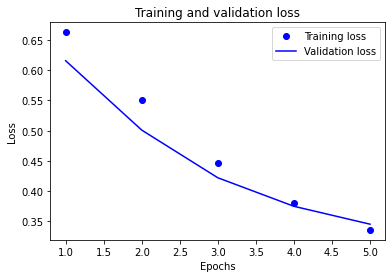

In [38]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

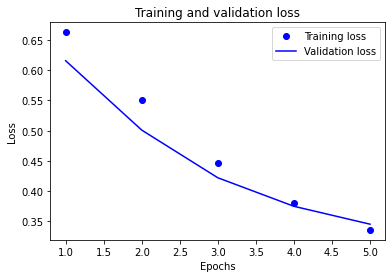

In [39]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [40]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3605 - accuracy: 0.8607
0.8602399826049805


In [41]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
  "it was blunt."
]

export_model.predict(examples)

array([[0.5899735 ],
       [0.48561388],
       [0.43793145],
       [0.5418375 ]], dtype=float32)